## Read the cleaned contents

In [19]:
import os
import re
from collections import defaultdict
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [20]:
def read_txt_files(folder_path):
    """Reads all .txt files in a given folder and stores their contents in a dictionary.

    Args:
        folder_path: The path to the folder containing the .txt files.

    Returns:
        A dictionary where the keys are the filenames (without the .txt extension) and the values are the file contents.
    """

    file_contents = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath,'r') as f:
                file_contents[filename[:-4]] = f.read() # [:-4] to remove the .txt extension
    return file_contents

In [21]:
folder_path = r"./onepiece_cleaned"
file_contents = read_txt_files(folder_path)


In [22]:
# Print the first key and value in the dictionary
key = list(file_contents.keys())[0]
value = file_contents[key]
print(f"Key: {key}")
print(f"Value: {value}")

Key: A O
Value: A O
is an infamous
New World
pirate
and
captain
of the
A O Pirates
.
He and his crew were subordinates to
Whitebeard
.
Appearance
[
]
A O is a very tall man with a long, square shaped face, hollow eyes under prominent eyebrows, dark sideburns that go all the way down to his chin, and greenish long wavy hair. On his head, he wears a yellow and brown striped bandanna and over it is a tricorn captain's hat with what appears to be his
Jolly Roger
on it, a white skull wearing an animal-like hood. He also wears a dark blue, open shirt with the sleeves rolled up and a ruffled collar, and elaborate earrings made up by three little jewels each on both ears.
Personality
[
]
Not much is known about A O's personality other than that he is very loyal to
Whitebeard
since he was willing to risk his own life to save
Ace
from execution instead of fleeing through the path he had cleared with his
power
.
He was overjoyed when
Luffy
saved Ace, cheering with his fellow allies.
Relationships

### Function to extract number of references and words of each character

In [ ]:
def generate_character_summary(char_data):
    unique_characters = set(char_data.keys())
    char_summary = {char: {"mentions": [], "word_count": 0, "mentioned_by": []} for char in unique_characters}

    # Precompile regex patterns for exact word matching, considering case sensitivity
    patterns = {char: re.compile(rf'\b{re.escape(char)}\b') for char in unique_characters}

    for character, content in char_data.items():
        word_count = len(content.split())
        char_summary[character]["word_count"] = word_count
        
        # Find mentioned characters using regex
        mentioned_chars = [
            char for char in unique_characters 
            if char != character and patterns[char].search(content)
        ]
        char_summary[character]["mentions"] = mentioned_chars

        # Update mentioned_by for each mentioned character
        for mentioned_char in mentioned_chars:
            char_summary[mentioned_char]["mentioned_by"].append(character)
    
    # Sort keys alphabetically
    sorted_char_summary = dict(sorted(char_summary.items()))
    return sorted_char_summary


In [107]:
summary = generate_character_summary(file_contents)

In [118]:
# Save summary as json
import json

with open("character_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

In [119]:
# Print the first key and value in the summary dictionary
key = list(summary.keys())[1]
value = summary[key]
print(f"Key: {key}")
print(f"Value: {value}")

Key: Abdullah
Value: {'mentions': ['Bobby Funk', 'Bartolomeo', 'Suleiman', 'Tank Lepanto', 'Bartholomew Kuma', 'Dagama', 'Riku Doldo III', 'Jeet', 'Pica', 'Kelly Funk', 'Ideo', 'Ucy', 'Abdullah', 'Sugar', 'Blue Gilly', 'Chinjao', 'Hajrudin', 'Issho', 'Cavendish', 'Bastille', 'King', 'Usopp', 'Bellamy', 'Elizabello II', 'Orlumbus'], 'word_count': 1769, 'mentioned_by': ['Abdullah', 'Bartholomew Kuma', 'Bastille', 'Bellamy', 'Blue Gilly', 'Boo', 'Cavendish', 'Chinjao', 'Dagama', 'Elizabello II', 'Hajrudin', 'Ideo', 'Jeet', 'Kelly Funk', 'Orlumbus', 'Pandaman', 'Pica', 'Sai', 'Suleiman', 'Tank Lepanto', 'Ucy']}


In [120]:

# Function 2: Analyze and plot distributions
def analyze_and_plot(char_summary: Dict[str, Dict[str, any]]):
    # Extract data
    mention_counts = [len(data["mentions"]) for data in char_summary.values()]
    in_reference_counts = [len(data["mentioned_by"]) for data in char_summary.values()]
    word_counts = [data["word_count"] for data in char_summary.values()]
    
    # Helper to calculate statistics
    def compute_stats(data: List[int]) -> Dict[str, float]:
        mean = np.mean(data)
        median = np.median(data)
        ci = stats.norm.interval(0.95, loc=mean, scale=np.std(data) / np.sqrt(len(data)))
        return {"mean": mean, "median": median, "ci_low": ci[0], "ci_high": ci[1]}

    # Compute statistics
    mention_stats = compute_stats(mention_counts)
    in_ref_stats = compute_stats(in_reference_counts)
    word_count_stats = compute_stats(word_counts)
    
    # Print statistics
    print("Mention Stats:", mention_stats)
    print("In-Reference Stats:", in_ref_stats)
    print("Word Count Stats:", word_count_stats)
    
    # Plot distributions
    plt.figure(figsize=(18, 6))
    
    # Mentions Plot
    plt.subplot(1, 3, 1)
    plt.hist(mention_counts, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Mentions Distribution\nMean: {mention_stats["mean"]:.2f}, Median: {mention_stats["median"]:.2f}, CI: ({mention_stats["ci_low"]:.2f}, {mention_stats["ci_high"]:.2f})')
    plt.xlabel('Number of Mentions')
    plt.ylabel('Frequency')
    
    # In-Reference Plot
    plt.subplot(1, 3, 2)
    plt.hist(in_reference_counts, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.title(f'In-References Distribution\nMean: {in_ref_stats["mean"]:.2f}, Median: {in_ref_stats["median"]:.2f}, CI: ({in_ref_stats["ci_low"]:.2f}, {in_ref_stats["ci_high"]:.2f})')
    plt.xlabel('Number of In-References')
    plt.ylabel('Frequency')
    
    # Word Count Plot
    plt.subplot(1, 3, 3)
    plt.hist(word_counts, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    plt.title(f'Word Count Distribution\nMean: {word_count_stats["mean"]:.2f}, Median: {word_count_stats["median"]:.2f}, CI: ({word_count_stats["ci_low"]:.2f}, {word_count_stats["ci_high"]:.2f})')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

Mention Stats: {'mean': 12.61036339165545, 'median': 8.0, 'ci_low': 11.99945693464033, 'ci_high': 13.221269848670572}
In-Reference Stats: {'mean': 12.61036339165545, 'median': 4.0, 'ci_low': 11.01153819429369, 'ci_high': 14.209188589017211}
Word Count Stats: {'mean': 1332.7294751009422, 'median': 540.0, 'ci_low': 1230.176966697039, 'ci_high': 1435.2819835048454}


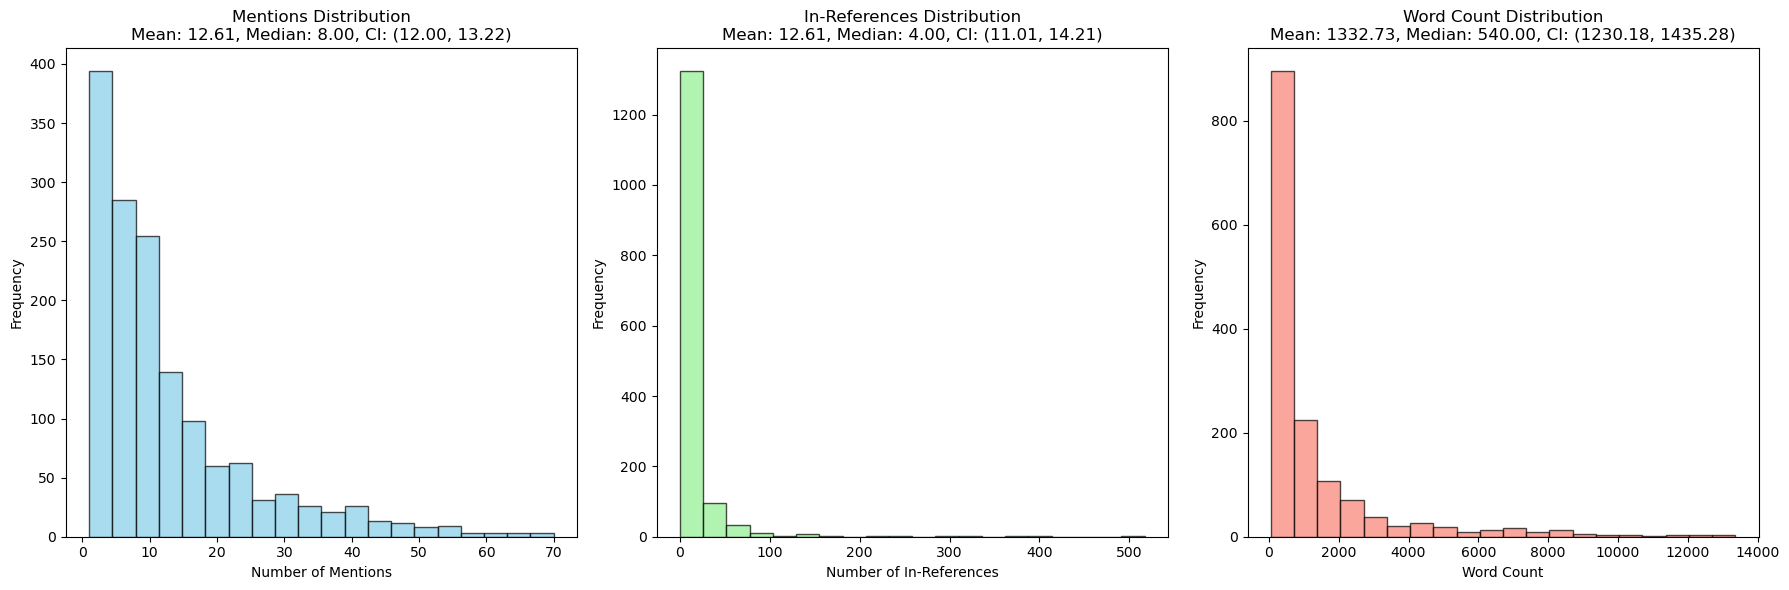

In [121]:
analyze_and_plot(summary)

To prune characters effectively using the three metrics (**in-mentions**, **word count**, and **out-mentions**), we can adopt ranking strategies that prioritize **in-mentions** and **word count** while still accounting for **out-mentions**. Below are some approaches to solve this:

---

### **Option 1: Weighted Scoring**
Assign weights to each metric based on its importance. Compute a total score for each character, and filter characters based on their scores:
1. **Define Weights**:
   - Assign higher weights to **in-mentions** and **word count** compared to **out-mentions**.
   - Example: `in-mentions = 0.4`, `word count = 0.4`, `out-mentions = 0.2`.
2. **Score Formula**:
   ```python
   score = 0.4 * normalized_in_mentions + 0.4 * normalized_word_count + 0.2 * normalized_out_mentions
   ```
   Normalize the values to a range of `[0, 1]` using min-max scaling:
   ```python
   normalized_value = (value - min_value) / (max_value - min_value)
   ```
3. **Sort and Filter**:
   - Rank characters by their scores and prune based on a threshold or keep the top N characters.

---

### **Option 2: Multi-Metric Ranking**
Rank characters separately by each metric and combine their rankings to create a composite rank:
1. **Rank by Each Metric**:
   - Create three sorted lists: 
     - By **in-mentions** (descending).
     - By **word count** (descending).
     - By **out-mentions** (descending).
   - Assign a rank to each character for each metric.
2. **Weighted Rank Sum**:
   - Compute a combined rank for each character using weights (e.g., `in-mentions_rank * 0.4 + word_count_rank * 0.4 + out_mentions_rank * 0.2`).
3. **Filter**:
   - Keep characters with the lowest combined ranks.

---

### **Option 3: Pareto Optimal Filtering**
Use a **Pareto frontier approach** to retain characters that are optimal with respect to the three metrics:
1. **Pareto Principle**:
   - A character is considered "better" if no other character outperforms it in all three metrics.
2. **Filter with Thresholds**:
   - Define a threshold for each metric (e.g., `in-mentions > 3`, `word count > 50`) and retain only characters satisfying these thresholds.

---

### **Option 4: Custom Rule-Based Filtering**
Define a set of rules to prune characters explicitly based on your priorities:
1. **Rules**:
   - Retain characters with **in-mentions > X** or **word count > Y** regardless of their out-mentions.
   - Optionally, remove characters with **out-mentions < Z**.
2. **Implementation**:
   - Iterate through the dictionary, applying the rules and removing characters that fail.

---

### **How to Choose?**
- **Weighted Scoring**: Flexible and provides a continuous score. Good if you want to rank characters and pick the top ones.
- **Multi-Metric Ranking**: Provides transparency in how rankings are combined. Better if you want to understand relative importance.
- **Pareto Filtering**: Useful for retaining the "best" characters without predefined thresholds. May require manual inspection of results.
- **Rule-Based Filtering**: Simple and fast if you know specific thresholds for pruning.

---

### Example Code: Weighted Scoring

```python
def prune_characters(char_summary, weights={"in": 0.4, "words": 0.4, "out": 0.2}, keep_top=10):
    # Extract metrics
    in_counts = [len(data["mentioned_by"]) for data in char_summary.values()]
    word_counts = [data["word_count"] for data in char_summary.values()]
    out_counts = [len(data["mentions"]) for data in char_summary.values()]
    
    # Normalize metrics
    def normalize(data):
        min_val, max_val = min(data), max(data)
        return [(x - min_val) / (max_val - min_val) if max_val > min_val else 0 for x in data]
    
    norm_in_counts = normalize(in_counts)
    norm_word_counts = normalize(word_counts)
    norm_out_counts = normalize(out_counts)
    
    # Compute weighted scores
    scores = {}
    for idx, char in enumerate(char_summary):
        scores[char] = (
            weights["in"] * norm_in_counts[idx] +
            weights["words"] * norm_word_counts[idx] +
            weights["out"] * norm_out_counts[idx]
        )
    
    # Sort characters by scores
    sorted_characters = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    # Keep top N characters
    pruned_summary = {char: char_summary[char] for char, score in sorted_characters[:keep_top]}
    return pruned_summary
```

### Example Code: Multi-Metric Ranking

```python
def prune_characters_by_rank(char_summary, weights={"in": 0.4, "words": 0.4, "out": 0.2}, keep_top=10):
    # Extract metrics
    in_counts = {char: len(data["mentioned_by"]) for char, data in char_summary.items()}
    word_counts = {char: data["word_count"] for char, data in char_summary.items()}
    out_counts = {char: len(data["mentions"]) for char, data in char_summary.items()}
    
    # Rank characters by each metric
    def rank(data):
        return {k: rank for rank, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[1], reverse=True), 1)}
    
    in_ranks = rank(in_counts)
    word_ranks = rank(word_counts)
    out_ranks = rank(out_counts)
    
    # Compute weighted rank sum
    scores = {
        char: (
            weights["in"] * in_ranks[char] +
            weights["words"] * word_ranks[char] +
            weights["out"] * out_ranks[char]
        )
        for char in char_summary
    }
    
    # Sort characters by scores
    sorted_characters = sorted(scores.items(), key=lambda x: x[1])
    
    # Keep top N characters
    pruned_summary = {char: char_summary[char] for char, score in sorted_characters[:keep_top]}
    return pruned_summary

def pareto_filter(char_summary):
    # Extract metrics
    metrics = [
        (char, len(data["mentioned_by"]), data["word_count"], len(data["mentions"]))
        for char, data in char_summary.items()
    ]
    
    # Pareto frontier computation
    pareto_frontier = []
    for char, in_count, word_count, out_count in metrics:
        if not any(
            other_in > in_count and other_words > word_count and other_out > out_count
            for _, other_in, other_words, other_out in metrics
        ):
            pareto_frontier.append(char)
    
    # Return filtered dictionary
    return {char: char_summary[char] for char in pareto_frontier}


def percentile_filter(char_summary, percentile=90):
    # Extract metrics
    in_counts = [len(data["mentioned_by"]) for data in char_summary.values()]
    word_counts = [data["word_count"] for data in char_summary.values()]
    out_counts = [len(data["mentions"]) for data in char_summary.values()]
    
    # Compute percentile thresholds
    in_threshold = np.percentile(in_counts, percentile)
    word_threshold = np.percentile(word_counts, percentile)
    out_threshold = np.percentile(out_counts, percentile)
    
    # Filter characters
    filtered_summary = {
        char: data for char, data in char_summary.items()
        if len(data["mentioned_by"]) >= in_threshold
        or data["word_count"] >= word_threshold
        or len(data["mentions"]) >= out_threshold
    }
    
    return filtered_summary
```
---

### Key Notes
1. **Pareto Filtering**:
   - Retains characters that cannot be strictly outperformed on all metrics by others.
   - Tends to keep a diverse set of "strong" characters.

2. **Percentile-Based Filtering**:
   - Removes characters that fall below the 90th percentile in **all** metrics.
   - Adjustable by changing the `percentile` parameter (e.g., to 85% or 95%).


**We can discuss the other strategies but for now I would keep the rank one**

In [122]:
# def prune_characters_by_rank(char_summary, weights={"in": 0.4, "words": 0.4, "out": 0.2}):
#     # Extract metrics
#     in_counts = {char: len(data["mentioned_by"]) for char, data in char_summary.items()}
#     word_counts = {char: data["word_count"] for char, data in char_summary.items()}
#     out_counts = {char: len(data["mentions"]) for char, data in char_summary.items()}
    
#     # Rank characters by each metric
#     def rank(data):
#         return {k: rank for rank, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[1], reverse=True), 1)}
    
#     in_ranks = rank(in_counts)
#     word_ranks = rank(word_counts)
#     out_ranks = rank(out_counts)
    
#     # Compute weighted rank sum
#     scores = {
#         char: (
#             weights["in"] * in_ranks[char] +
#             weights["words"] * word_ranks[char] +
#             weights["out"] * out_ranks[char]
#         )
#         for char in char_summary
#     }
    
#     # Sort characters by scores
#     sorted_characters = sorted(scores.items(), key=lambda x: x[1])

#     return sorted_characters, in_ranks, word_ranks, out_ranks


In [2]:
import json
# Read the character summary from the JSON file
with open("character_summary.json", "r") as f:
    summary = json.load(f)

In [3]:
def sort_summary_by_metric(char_summary, metric):
    """
    Sorts the character summary dictionary by the specified metric.

    Args:
        char_summary (dict): Dictionary containing character data.
        metric (str): The metric to sort by ('mentioned_by', 'word_count', 'mentions').

    Returns:
        dict: Sorted dictionary based on the specified metric.
        list: Sorted list of tuples (character, metric value) for debugging or inspection.
    """
    # Sort the dictionary by the specified metric
    sorted_summary = dict(sorted(char_summary.items(), key=lambda x: len(x[1][metric]) if metric in ['mentioned_by', 'mentions'] else x[1][metric], reverse=True))
    
    # Extract values for debugging/inspection
    metric_values = [(char, len(data[metric]) if metric in ['mentioned_by', 'mentions'] else data[metric]) for char, data in sorted_summary.items()]
    
    return sorted_summary, metric_values


In [4]:
sorted_by_in, in_values = sort_summary_by_metric(summary, 'mentioned_by')
print("Sorted by In-Mentions:")
for char, value in in_values:
    print(f"{char}: {value}")

Sorted by In-Mentions:
Monkey D. Luffy: 517
Sanji: 405
King: 379
Nami: 323
Usopp: 291
Kaidou: 246
Vegapunk: 245
Franky: 225
Roronoa Zoro: 215
Jinbe: 214
Nico Robin: 180
Portgas D. Ace: 171
Brook: 155
Some: 150
Donquixote Doflamingo: 143
Shanks: 139
Den: 136
Kin'emon: 134
Queen: 133
Crocodile: 120
Sengoku: 117
Tony Tony Chopper: 115
Kouzuki Oden: 100
Sabo: 99
Gol D. Roger: 95
Marco: 95
Buggy: 94
Caesar Clown: 93
Kurozumi Orochi: 90
Bartholomew Kuma: 85
Tama: 83
Skull: 80
Lily: 78
Boa Hancock: 76
Amazon: 75
Charlotte Pudding: 75
Charlotte Linlin: 74
Eustass Kid: 72
Merry: 72
Yamato: 69
Nekomamushi: 68
Jack: 67
Koby: 65
Arlong: 63
Kouzuki Momonosuke: 63
Raizo: 63
Charlos: 62
Shirahoshi: 62
Uta: 61
Jewelry Bonney: 60
Nefertari Vivi: 60
Shimotsuki Yasuie: 60
Monkey D. Garp: 58
Edward Newgate: 57
Going Merry: 57
Bartolomeo: 56
Neptune: 55
Oars: 55
Rob Lucci: 55
Silvers Rayleigh: 55
Smoker: 55
Sugar: 55
House: 54
Tsuru: 54
Inuarashi: 53
Marshall D. Teach: 53
Gecko Moria: 51
Hatchan: 51
Leo: 5

In [5]:
# Sort by word count
sorted_by_words, word_values = sort_summary_by_metric(summary, 'word_count')
print("\nSorted by Word Count:")
for char, value in word_values:
    print(f"{char}: {value}")


Sorted by Word Count:
Kaidou: 13361
Monkey D. Garp: 13206
Sabo: 12700
Kouzuki Momonosuke: 12569
Vegapunk: 12435
Kouzuki Oden: 12278
Jewelry Bonney: 11795
Eustass Kid: 11509
Borsalino: 11456
Boa Hancock: 11450
Queen: 10945
Kuzan: 10886
Bartholomew Kuma: 10638
Marshall D. Teach: 10579
Sakazuki: 10341
Portgas D. Ace: 10018
Yamato: 9755
Jaygarcia Saturn: 9547
Carrot: 9507
Buggy: 9367
Shanks: 9319
Hody Jones: 9106
Kurozumi Orochi: 8914
Vinsmoke Judge: 8778
Sengoku: 8704
Emporio Ivankov: 8674
Issho: 8641
King: 8637
Capone Bege: 8586
Charlotte Pudding: 8548
Charlotte Katakuri: 8444
Edward Newgate: 8416
Kikunojo: 8357
Bartolomeo: 8295
Kyros: 8198
Gecko Moria: 8161
Dracule Mihawk: 8046
Marco: 7955
Crocodile: 7815
Rob Lucci: 7791
Galdino: 7512
Koby: 7486
Raizo: 7470
Tashigi: 7468
Wapol: 7445
Caesar Clown: 7391
Gol D. Roger: 7368
Kin'emon: 7359
Bentham: 7318
Going Merry: 7255
Arlong: 7242
Rebecca: 7162
Nefertari Vivi: 7103
Silvers Rayleigh: 6988
Hatchan: 6913
Vinsmoke Reiju: 6894
Enel: 6861
Monk

In [6]:
sorted_by_out, out_values = sort_summary_by_metric(summary, 'mentions')
print("\nSorted by Out-Mentions:")
for char, value in out_values:
    print(f"{char}: {value}")


Sorted by Out-Mentions:
Borsalino: 70
Monkey D. Garp: 69
Pandaman: 69
Carrot: 65
Hatchan: 65
Kaidou: 65
Kuzan: 62
Sengoku: 62
Marco: 61
Bartholomew Kuma: 59
Eustass Kid: 59
Boa Hancock: 57
Koby: 56
Nekomamushi: 55
Sakazuki: 55
Yamato: 55
Kouzuki Momonosuke: 54
Inuarashi: 53
Kikunojo: 53
Marshall D. Teach: 53
Portgas D. Ace: 53
Leo: 52
Sabo: 52
Bepo: 51
Going Merry: 51
Jaygarcia Saturn: 51
Kurozumi Tama: 51
Rob Lucci: 51
Zeus: 51
Tashigi: 49
Bartolomeo: 48
Gecko Moria: 48
Kawamatsu: 48
Kurozumi Kanjuro: 48
Shanks: 48
Jewelry Bonney: 47
Pedro: 47
Queen: 47
X Drake: 47
Dracule Mihawk: 46
Silvers Rayleigh: 46
Basil Hawkins: 45
Killer: 45
Cavendish: 44
Gol D. Roger: 44
Izou: 44
Jack-in-the-Box: 44
Rug Bear: 44
Shinobu: 44
Stussy: 44
Wall Zombie: 44
Camie: 43
Jean Bart: 43
Rebecca: 43
George Black: 42
Hajrudin: 42
Raizo: 42
Roche Tomson: 42
Sentomaru: 42
Shachi: 42
Shirahoshi: 42
Buggy: 41
Edward Newgate: 41
Helmeppo: 41
Kin'emon: 41
Kouzuki Oden: 41
Nefertari Vivi: 41
Sai: 41
Galdino: 40
P

**Issues with Some and Queen Den And (my solution is to set to nan the inlinks) or manually**

In [7]:
summary['Queen']

{'mentions': ['Kikunojo',
  'Queen',
  'Kaidou',
  'Page One',
  'Yamato',
  'Bao',
  'Vegapunk',
  'Inuarashi',
  'Ashura Doji',
  'X Drake',
  'Charlotte Linlin',
  'Mummy',
  'Aramaki',
  "Kin'emon",
  'Skull',
  'Kouzuki Momonosuke',
  'Kouzuki Oden',
  'Basil Hawkins',
  'Tama',
  'Sanji',
  'Charlotte Perospero',
  'Shimotsuki Yasuie',
  'Marco',
  'Madilloman',
  'Denjiro',
  'Bao Huang',
  'Scratchmen Apoo',
  'Tony Tony Chopper',
  'Roronoa Zoro',
  'Vinsmoke Judge',
  'Hyougoro',
  'Shinobu',
  "Who's-Who",
  'Babanuki',
  'Franky',
  'Eustass Kid',
  'King',
  'Daifugo',
  'Ulti',
  'Monkey D. Luffy',
  'Monster',
  'Raizo',
  'Alpacaman',
  'Some',
  'Caesar Clown',
  'Jack',
  'Heat'],
 'word_count': 10945,
 'mentioned_by': ['Aladine',
  'Aramaki',
  'Arlong',
  'Ashura Doji',
  'Babanuki',
  'Ban Dedessinée',
  'Basil Hawkins',
  'Battaman',
  'Beegirl',
  'Bentham',
  'Briscola',
  'Buckingham Stussy',
  'Caesar Clown',
  'Camie',
  'Caribou',
  'Carrot',
  'Charlos',
  

In [8]:
summary['Some']

{'mentions': ['Queen',
  'Kaidou',
  'Yamato',
  'Brook',
  'Skull',
  'Kurozumi Orochi',
  'Sanji',
  'Tsuru',
  'Chuji',
  'Raizo',
  'Some',
  'Tsugaru Umi'],
 'word_count': 818,
 'mentioned_by': ['Adele',
  'Aladine',
  'Amadob',
  'Arthur',
  'Attach',
  'Baggaley',
  'Bartolomeo',
  'Bell-mère',
  'Bellamy',
  'Bentham',
  'Bizarre',
  'Blondie',
  'Bobbin',
  'Borsalino',
  'Brocca',
  'Buchi',
  'Buckingham Stussy',
  'Bulldog',
  'Cands',
  'Carne',
  'Cavendish',
  'Charlotte Brownie',
  'Charlotte Broyé',
  'Charlotte Cracker',
  'Charlotte Katakuri',
  'Charlotte Kato',
  'Charlotte Linlin',
  'Charlotte Mobile',
  'Charlotte Moscato',
  'Charlotte Newgo',
  'Charlotte Newichi',
  'Charlotte Newji',
  'Charlotte Newsan',
  'Charlotte Praline',
  'Charlotte Pudding',
  'Charlotte Zuccotto',
  'Chicken',
  'Choi',
  'Chuji',
  'Conney',
  'Coribou',
  'Crocus',
  'Daidalos',
  'Daikoku',
  'Daz Bonez',
  'Decalvan Brothers',
  'Diez Barrels',
  'Doll',
  'Donquixote Rosinante

In [9]:
summary['Den'] # Issue because Den Den Mushi

{'mentions': ['Kokoro',
  'Jinbe',
  'Arlong',
  'Shirahoshi',
  'Megalo',
  'Fisher Tiger',
  'Tom',
  'Den',
  'Sanji',
  'Iceburg',
  'Hatchan',
  'Otohime',
  'Tony Tony Chopper',
  'Hody Jones',
  'Franky',
  'Monkey D. Luffy',
  'Camie'],
 'word_count': 620,
 'mentioned_by': ['And',
  'Aramaki',
  'Bakezo',
  'Bartolomeo',
  'Bas',
  'Basil Hawkins',
  'Bastille',
  'Bentham',
  'Bepo',
  'Blueno',
  'Bobbin',
  'Borsalino',
  'Buggy',
  'Camie',
  'Chadros Higelyges',
  'Charlotte Galette',
  "Charlotte Mont-d'Or",
  'Charlotte Myukuru',
  'Charlotte Opera',
  'Charlotte Perospero',
  'Charlotte Pudding',
  'Clou D. Clover',
  'Crocus',
  'Dellinger',
  'Den',
  'Diamante',
  'Domino',
  'Donquixote Rosinante',
  'Duval',
  'Emet',
  'Emporio Ivankov',
  'Ethanbaron V. Nusjuro',
  'Eustass Kid',
  'Fukaboshi',
  'Fukurou',
  'Funkfreed',
  'Gal',
  'Galdino',
  'Gambia',
  'Gancho',
  'George Black',
  'Ginny',
  'Guernika',
  'Gyaro',
  'Hammond',
  'Hannyabal',
  'Hatchan',
  

In [10]:
summary['And']

{'mentions': ['Zambai',
  'Kerville',
  'Peepley Lulu',
  'Kokoro',
  'Cerberus',
  'Paulie',
  'Oimo',
  'Kashii',
  'Den',
  'Tilestone',
  'Tony Tony Chopper',
  'Spandam',
  'Hound',
  'Roronoa Zoro',
  'Bas',
  'And',
  'Franky',
  'Nami'],
 'word_count': 1097,
 'mentioned_by': ['Acilia',
  'And',
  'Bas',
  'Basil Hawkins',
  'Charlotte Pudding',
  'Conis',
  'Edward Newgate',
  'Fillonce',
  'Gaikotsu Yukichi',
  'Gol D. Roger',
  'Hannyabal',
  'Hera',
  'Kerville',
  'Kumaguchi Ichiro',
  'Usaguchi Hideo']}

In [13]:
def analyze_problematic_characters(char_summary, problematic_chars):
    """
    Analyzes the problematic characters and categorizes their references.

    Args:
        char_summary (dict): Dictionary containing character data.
        problematic_chars (list): List of problematic characters to analyze.

    Returns:
        dict: Dictionary with three lists for each problematic character:
              - Common references (in and out)
              - Only in-references
              - Only out-references
    """
    problematic_dictionary = {}

    for char in problematic_chars:
        if char not in char_summary:
            print(f"Character {char} not found in char_summary.")
            continue
        
        in_refs = set(char_summary[char]["mentioned_by"])
        out_refs = set(char_summary[char]["mentions"])
        
        common_refs = in_refs.intersection(out_refs)
        only_in_refs = in_refs.difference(out_refs)
        only_out_refs = out_refs.difference(in_refs)
        
        problematic_dictionary[char] = {
            "common_references": list(common_refs),
            "only_in_references": list(only_in_refs),
            "only_out_references": list(only_out_refs),
        }

    return problematic_dictionary

In [14]:
problematic_chars = ["Queen", "Some", "Den", "And"]

problematic_dict = analyze_problematic_characters(summary, problematic_chars)

for char, data in problematic_dict.items():
    print(f"Character: {char}")
    print(f"  Common References: {data['common_references']}")
    print(f"  Only In-References: {data['only_in_references']}")
    print(f"  Only Out-References: {data['only_out_references']}")

Character: Queen
  Common References: ['Aramaki', 'Caesar Clown', 'Kaidou', 'Marco', 'Babanuki', 'Daifugo', 'Some', "Kin'emon", 'Hyougoro', 'Scratchmen Apoo', 'Inuarashi', 'Raizo', "Who's-Who", 'Ulti', 'Sanji', 'Basil Hawkins', 'Shinobu', 'Jack', 'King', 'Queen', 'Kikunojo', 'Denjiro', 'Vegapunk', 'X Drake', 'Charlotte Perospero', 'Eustass Kid', 'Page One', 'Ashura Doji']
  Only In-References: ['Charlotte Moscato', 'Kawamatsu', 'Himuro', 'George Black', 'Izou', 'Gorishiro', 'Arlong', 'Nefertari Vivi', 'Ikaros Much', 'Emporio Ivankov', 'Charlotte Effilée', 'Mizerka', 'Hody Jones', 'Kazekage', 'Charlotte Poire', 'Battaman', 'Charlotte Dosmarche', 'Charlotte Raisin', 'Kurozumi Tama', 'Charlotte Daifuku', 'Usunoro', 'Miyagi', 'Tsunokkov', 'Hatcha', 'Hotei', 'Minister of the Right', 'Willie Gallon', 'Charlotte Mash', 'Hamlet', 'Charlotte Mobile', 'Briscola', 'Carrot', 'Charlotte Cornstarch', 'Omasa', 'Daikoku', 'Hatsume', 'Jewelry Bonney', 'Roche Tomson', 'Charlotte Amande', "Charlotte Mont

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_and_analyze_directed_sub_networks(char_summary, problematic_chars):
    """
    Plots and analyzes directed sub-networks for the specified problematic characters.

    Args:
        char_summary (dict): Dictionary containing character data.
        problematic_chars (list): List of problematic characters to analyze.

    Returns:
        dict: Dictionary containing the number of in-links and out-links for each node in each sub-network.
    """
    analysis_results = {}

    for char in problematic_chars:
        if char not in char_summary:
            print(f"Character {char} not found in char_summary.")
            continue

        # Sub-network nodes: characters mentioning the problematic character
        in_references = set(char_summary[char]["mentioned_by"])
        out_references = set(char_summary[char]["mentions"])
        sub_network_nodes = in_references.union(out_references)

        # Build the directed sub-network
        G = nx.DiGraph()

        # Add nodes
        G.add_nodes_from(sub_network_nodes)

        # Add directed edges
        for node in sub_network_nodes:
            for target in char_summary[node]["mentions"]:
                if target in sub_network_nodes:
                    G.add_edge(node, target)
            for source in char_summary[node]["mentioned_by"]:
                if source in sub_network_nodes:
                    G.add_edge(source, node)

        # Compute node degrees for visualization
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())
        node_sizes = [in_degrees[node] * 20 + 50 for node in G.nodes()]  # Adjust node sizes
        node_colors = [out_degrees[node] for node in G.nodes()]

        # Plot the directed sub-network
        plt.figure(figsize=(12, 8))
        pos = nx.kamada_kawai_layout(G)  # Sparser layout for better visibility
        nodes = nx.draw_networkx_nodes(
            G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues, alpha=0.8
        )
        nx.draw_networkx_edges(
            G, pos, edge_color="gray", arrows=True, arrowsize=10, alpha=0.7
        )
        nx.draw_networkx_labels(
            G, pos, font_size=8, font_color="black", font_weight="bold"
        )

        # Add colorbar for node out-degree
        ax = plt.gca()  # Get the current Axes
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
        sm.set_array([])  # Required for ScalarMappable to work
        cbar = plt.colorbar(sm, ax=ax, label="Out-Degree")  # Tie colorbar to Axes

        # Finalize the plot
        plt.title(f"Directed Sub-Network for {char}", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        # Analyze links for each node
        node_in_links = {node: G.in_degree(node) for node in G.nodes()}
        node_out_links = {node: G.out_degree(node) for node in G.nodes()}
        analysis_results[char] = {
            "in_links": node_in_links,
            "out_links": node_out_links,
        }

        # Print the number of in-links and out-links for each node
        print(f"\nDirected Sub-Network Analysis for {char}:")
        print("  In-Links:")
        for node, links in node_in_links.items():
            print(f"    {node}: {links} in-links")
        print("  Out-Links:")
        for node, links in node_out_links.items():
            print(f"    {node}: {links} out-links")

    return analysis_results


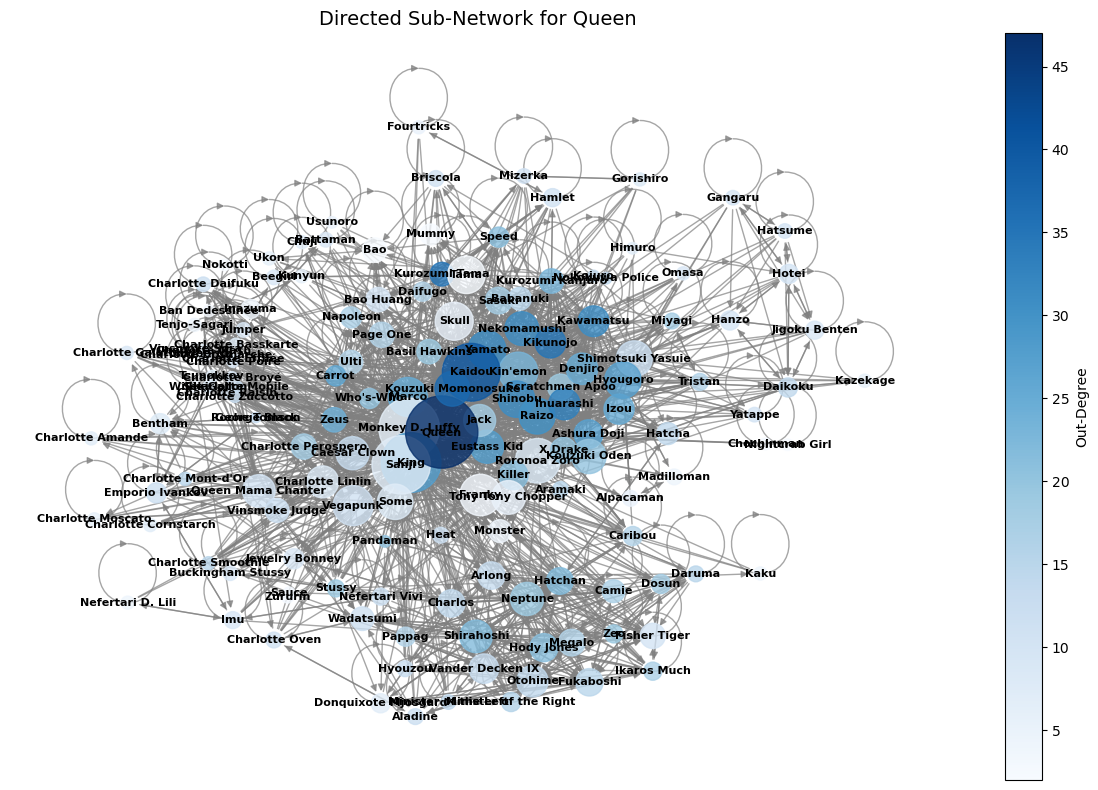


Directed Sub-Network Analysis for Queen:
  In-Links:
    Aramaki: 4 in-links
    Charlotte Moscato: 2 in-links
    Kawamatsu: 22 in-links
    Marco: 37 in-links
    Himuro: 1 in-links
    George Black: 0 in-links
    Izou: 21 in-links
    Gorishiro: 2 in-links
    Arlong: 17 in-links
    Monkey D. Luffy: 93 in-links
    Nefertari Vivi: 5 in-links
    Ulti: 12 in-links
    Who's-Who: 8 in-links
    Ikaros Much: 6 in-links
    Emporio Ivankov: 8 in-links
    Basil Hawkins: 13 in-links
    Charlotte Effilée: 1 in-links
    Mizerka: 3 in-links
    Hody Jones: 18 in-links
    Kazekage: 2 in-links
    Charlotte Poire: 1 in-links
    Monster: 11 in-links
    Shimotsuki Yasuie: 31 in-links
    Battaman: 3 in-links
    King: 90 in-links
    Charlotte Dosmarche: 1 in-links
    Charlotte Raisin: 1 in-links
    Charlotte Perospero: 14 in-links
    Bao: 13 in-links
    Yamato: 35 in-links
    Kurozumi Tama: 12 in-links
    Charlotte Daifuku: 3 in-links
    Usunoro: 1 in-links
    Miyagi: 4 in-link

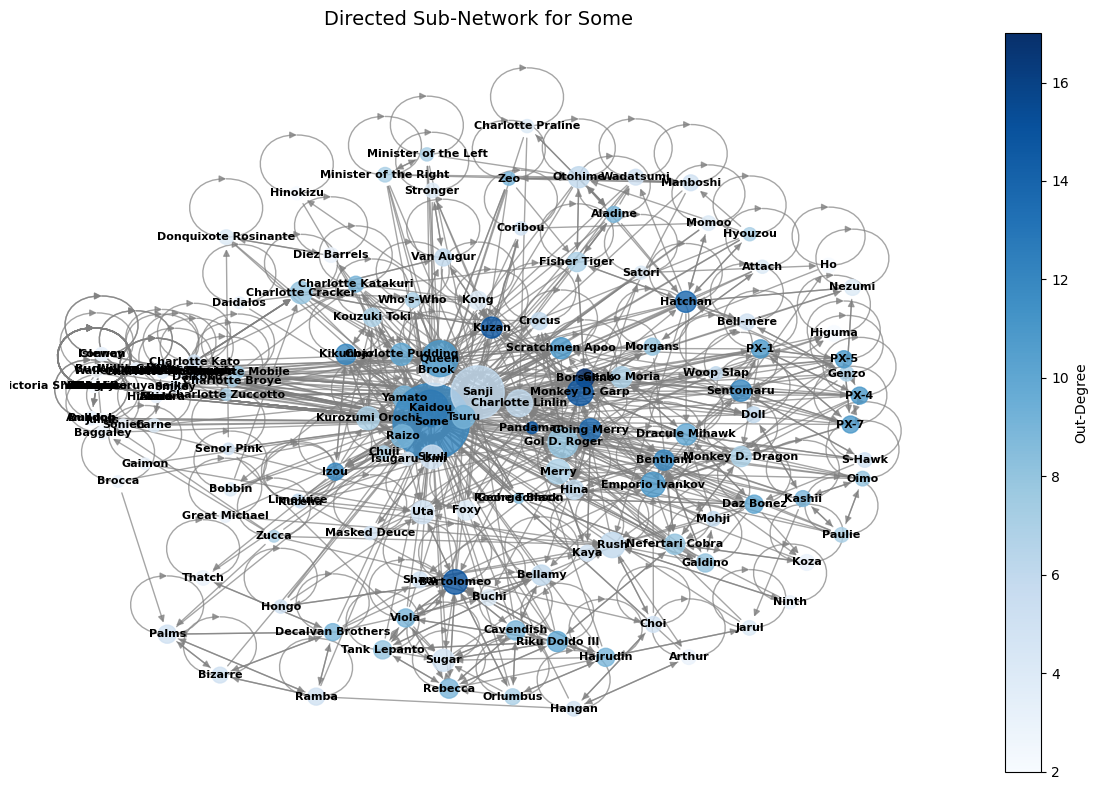


Directed Sub-Network Analysis for Some:
  In-Links:
    Kureha: 1 in-links
    Charlotte Moscato: 1 in-links
    Senor Pink: 1 in-links
    Going Merry: 10 in-links
    Hajrudin: 6 in-links
    Sham: 4 in-links
    Charlotte Praline: 2 in-links
    George Black: 0 in-links
    Izou: 5 in-links
    Hinokizu: 2 in-links
    Masked Deuce: 2 in-links
    Who's-Who: 3 in-links
    Kurozumi Orochi: 11 in-links
    Doll: 4 in-links
    Emporio Ivankov: 13 in-links
    Jarul: 3 in-links
    Bell-mère: 4 in-links
    Borsalino: 6 in-links
    Hasami: 1 in-links
    Buchi: 4 in-links
    PX-4: 5 in-links
    Dracule Mihawk: 9 in-links
    Sugar: 10 in-links
    Yamato: 11 in-links
    Charlotte Kato: 2 in-links
    Ho: 3 in-links
    Oimo: 3 in-links
    Attach: 2 in-links
    Charlotte Newichi: 0 in-links
    Kouzuki Toki: 6 in-links
    Hongo: 2 in-links
    Patty: 2 in-links
    Galdino: 6 in-links
    Genzo: 3 in-links
    PX-5: 5 in-links
    Mero: 1 in-links
    Minister of the Right: 3 i

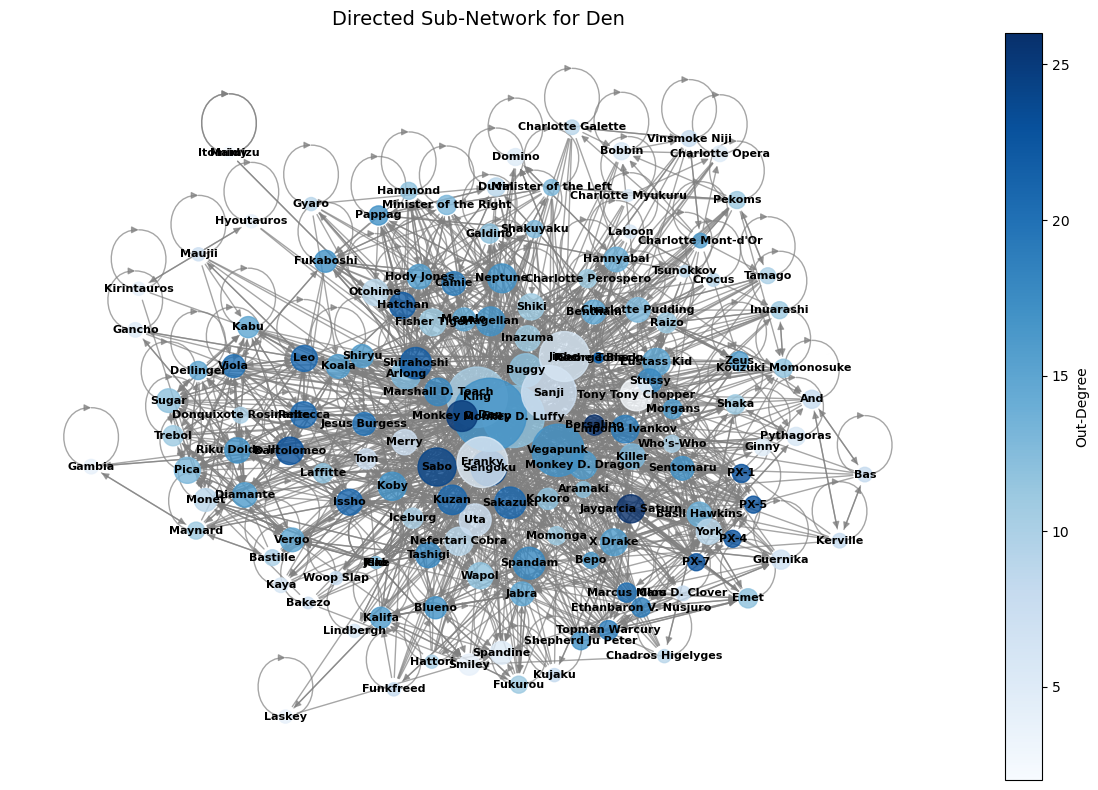


Directed Sub-Network Analysis for Den:
  In-Links:
    Magellan: 19 in-links
    Dellinger: 6 in-links
    Aramaki: 4 in-links
    Kirintauros: 2 in-links
    Spandine: 11 in-links
    Kalifa: 9 in-links
    Hammond: 5 in-links
    Ginny: 5 in-links
    Pekoms: 5 in-links
    George Black: 0 in-links
    Charlotte Opera: 4 in-links
    Sakazuki: 23 in-links
    Arlong: 20 in-links
    Monkey D. Luffy: 97 in-links
    Who's-Who: 5 in-links
    Duval: 6 in-links
    Emporio Ivankov: 17 in-links
    Basil Hawkins: 13 in-links
    Hody Jones: 13 in-links
    Gancho: 3 in-links
    Borsalino: 8 in-links
    Maynard: 5 in-links
    Topman Warcury: 7 in-links
    Domino: 5 in-links
    King: 92 in-links
    Tashigi: 14 in-links
    PX-4: 5 in-links
    Charlotte Perospero: 6 in-links
    Sugar: 12 in-links
    Sabo: 35 in-links
    Chadros Higelyges: 2 in-links
    Buggy: 26 in-links
    Jero: 1 in-links
    Galdino: 7 in-links
    Tsunokkov: 1 in-links
    Clou D. Clover: 3 in-links
    Gam

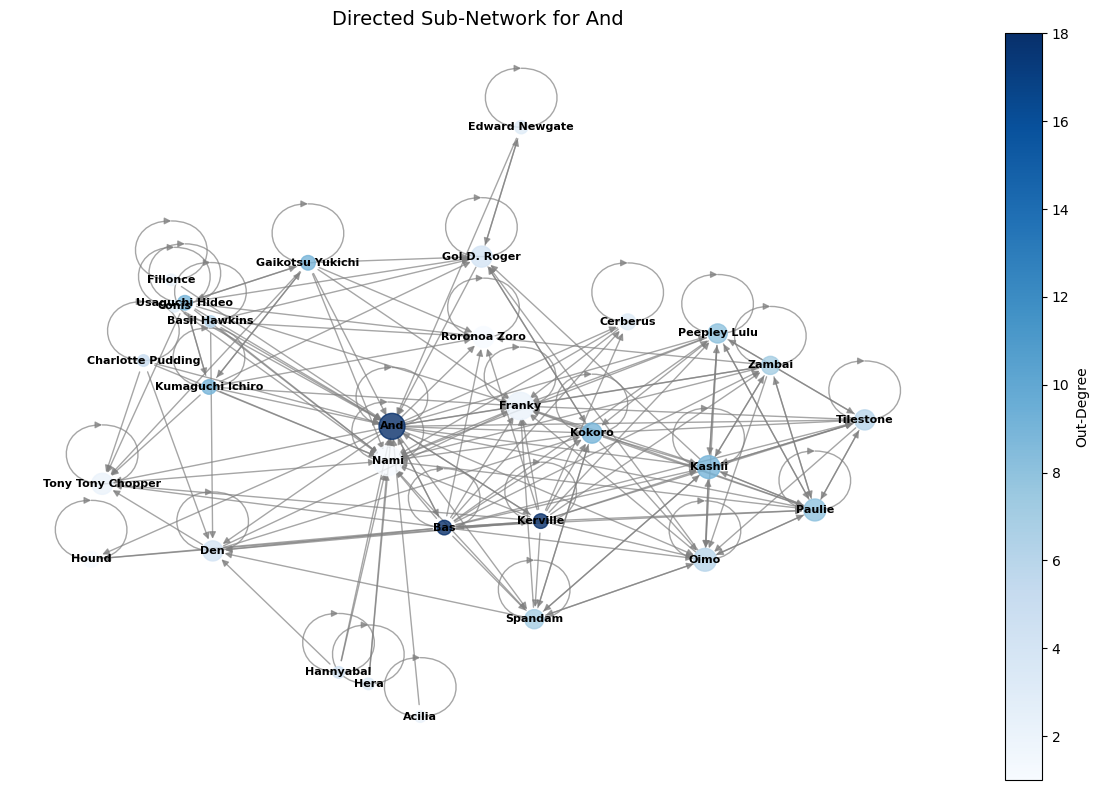


Directed Sub-Network Analysis for And:
  In-Links:
    Zambai: 6 in-links
    Cerberus: 4 in-links
    Tilestone: 8 in-links
    Franky: 17 in-links
    Peepley Lulu: 7 in-links
    Fillonce: 1 in-links
    Usaguchi Hideo: 3 in-links
    Kokoro: 8 in-links
    Gol D. Roger: 9 in-links
    Edward Newgate: 2 in-links
    Roronoa Zoro: 9 in-links
    Conis: 1 in-links
    Charlotte Pudding: 1 in-links
    Bas: 3 in-links
    Basil Hawkins: 1 in-links
    Kerville: 3 in-links
    Nami: 20 in-links
    Kashii: 11 in-links
    Hound: 4 in-links
    Tony Tony Chopper: 9 in-links
    Spandam: 7 in-links
    Acilia: 1 in-links
    Hannyabal: 1 in-links
    And: 15 in-links
    Den: 8 in-links
    Paulie: 10 in-links
    Kumaguchi Ichiro: 3 in-links
    Oimo: 11 in-links
    Gaikotsu Yukichi: 3 in-links
    Hera: 1 in-links
  Out-Links:
    Zambai: 7 out-links
    Cerberus: 3 out-links
    Tilestone: 6 out-links
    Franky: 2 out-links
    Peepley Lulu: 8 out-links
    Fillonce: 2 out-links
   

In [39]:
problematic_chars = ["Queen", "Some", "Den", "And"]
analysis_results = plot_and_analyze_directed_sub_networks(summary, problematic_chars)